In [2]:
import numpy as np 
import pandas as pd 
import os 
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix #lets visualise the model predictions 
import seaborn as sns
from sklearn.metrics import accuracy_score

In [50]:
train = Path('./kaggle/train/') #getting the path of the train dataset
train_filepaths = list(train.glob(r'**/*.jpg')) #glob (short for global) is used to return all file paths that match a specific pattern

valid = Path('./kaggle/validation/')#for valid dataset
valid_filepaths = list(valid.glob(r'**/*.jpg'))

test = Path('./kaggle/test/')#for test dataset
test_filepaths = list(test.glob(r'**/*.jpg'))

user_input = Path('./kaggle/user_input/')#for user input dataset
user_input_filepaths = list(user_input.glob(r'**/*.jpg'))

In [39]:
def process_img(filepath): # passing the filepaths of datasets
    
    labels = [str(filepath[i]).split("\\")[-2] #here we are trying to extract the labels for the fruits and veggies by using .split method and
              for i in range(len(filepath))] #since names are secound last word we used [-2] to get that particular name
    # print(labels)
    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label') 
    
    df = pd.concat([filepath, labels], axis=1) 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [51]:
train_df = process_img(train_filepaths) 
valid_df = process_img(valid_filepaths)
test_df = process_img(test_filepaths)
user_input_df = process_img(user_input_filepaths)

In [135]:
train_df.head()

,FilePath,Label
0,kaggle\train\lemon\Image_53.jpg,lemon
1,kaggle\train\cucumber\Image_58.jpg,cucumber
2,kaggle\train\pineapple\Image_1.jpg,pineapple
3,kaggle\train\sweetcorn\Image_5.jpg,sweetcorn
4,kaggle\train\soy beans\Image_86.jpg,soy beans


In [136]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(set(train_df.Label))}\n')
print(f'Labels: {set(train_df.Label)}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: {'jalepeno', 'lettuce', 'cauliflower', 'kiwi', 'cabbage', 'tomato', 'sweetcorn', 'spinach', 'watermelon', 'eggplant', 'soy beans', 'grapes', 'ginger', 'turnip', 'peas', 'beetroot', 'pomegranate', 'potato', 'carrot', 'paprika', 'apple', 'onion', 'bell pepper', 'garlic', 'raddish', 'cucumber', 'corn', 'capsicum', 'chilli pepper', 'pear', 'sweetpotato', 'banana', 'orange', 'pineapple', 'mango', 'lemon'}


In [137]:
print(f'Labels: {set(test_df.Label)}')

Labels: {'jalepeno', 'lettuce', 'cauliflower', 'kiwi', 'cabbage', 'tomato', 'sweetcorn', 'spinach', 'watermelon', 'eggplant', 'grapes', 'soy beans', 'ginger', 'turnip', 'peas', 'beetroot', 'pomegranate', 'potato', 'carrot', 'paprika', 'apple', 'onion', 'bell pepper', 'garlic', 'raddish', 'corn', 'cucumber', 'capsicum', 'chilli pepper', 'sweetpotato', 'pear', 'banana', 'orange', 'pineapple', 'mango', 'lemon'}


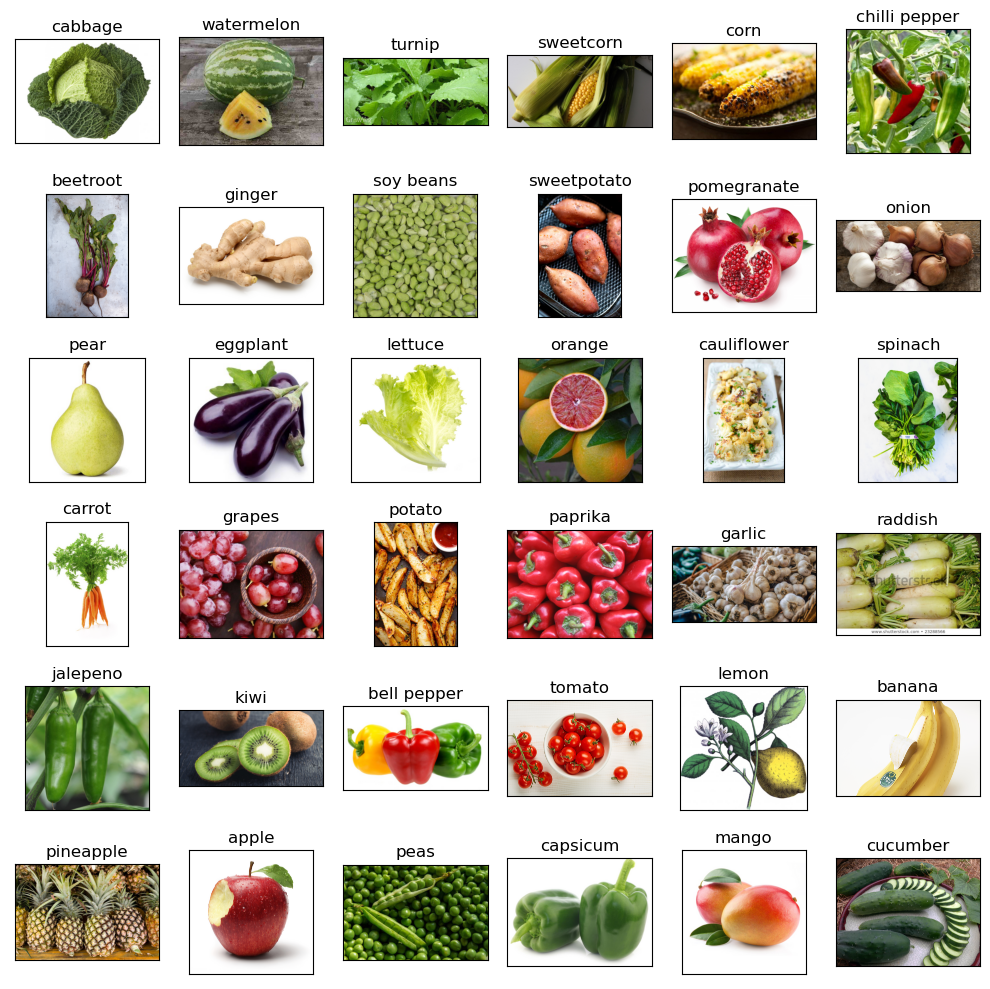

In [52]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index() #we want to see unique images so we are dropping duplicates and since we dont
                                                                                    #want to mess up the original df we are coping it using .copy()

fig, axes = plt.subplots(6,6, figsize=(10,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.FilePath[i]))
    ax.set_title(unique_labels.Label[i], fontsize=12)
    
plt.tight_layout()
plt.show()

In [53]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# random images from internet
random_images = data_gen.flow_from_dataframe(
    dataframe=user_input_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 2 validated image filenames belonging to 1 classes.


In [10]:
base_model =  tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
) #this is our base model 

base_model.trainable = False # we dont want to train the intial weights so we use .trainable = False 

In [58]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [12]:
inputs = base_model.input # this is our input layer which is the base_model's input

x = tf.keras.layers.Dense(128, activation='relu')(base_model.output) #here we passed this base_model.output coz on top of our x layer we want the output(bottom) layer of base_model
x = tf.keras.layers.Dense(256, activation='relu')(x) 

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)# here we have 36 diff classes so we take 36 as output

model = tf.keras.Model(inputs=inputs, outputs=outputs) # we are passing in our inputs and outputs to our model now

model.compile(                                           #lets just compile everthing together 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = model.fit(                    #fit the model 
    train_images,
    validation_data=valid_images,
    batch_size = 32,
    epochs=5,
    callbacks=[                   #we are using callbacks for early stopping in case our model doesn't show any improvement after 2 epochs monitoring the monitering the validation loss
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=2,
            restore_best_weights=True #it literally means wat u think (simpleeeeee)
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 143s 2s/step - loss: 1.6826 - accuracy: 0.5506 - val_loss: 0.4866 - val_accuracy: 0.8353
Epoch 2/5
90/90 [==============================] - 126s 1s/step - loss: 0.5451 - accuracy: 0.8231 - val_loss: 0.2862 - val_accuracy: 0.9029
Epoch 3/5
90/90 [==============================] - 131s 1s/step - loss: 0.3226 - accuracy: 0.8942 - val_loss: 0.1994 - val_accuracy: 0.9412
Epoch 4/5
90/90 [==============================] - 132s 1s/step - loss: 0.2108 - accuracy: 0.9317 - val_loss: 0.2159 - val_accuracy: 0.9382
Epoch 5/5
90/90 [==============================] - 137s 2s/step - loss: 0.1689 - accuracy: 0.9419 - val_loss: 0.1960 - val_accuracy: 0.9471


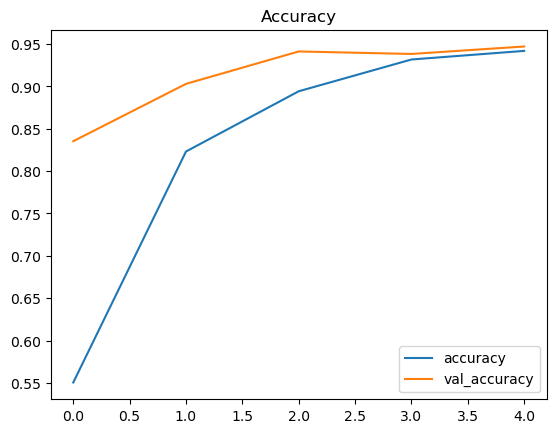

In [25]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()  # we are plotting the train and validation accuracy to check on if its overfitting 
plt.title('Accuracy')
plt.show()

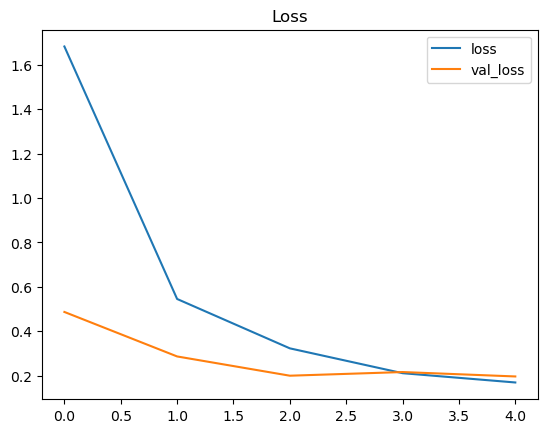

In [32]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [72]:
pred = model.predict(random_images) #its predicting time , our model will try to predict the prob of the particular class 
pred = np.argmax(pred, axis=1) # we are seeing the highest prob value and taking the index of it  

1/1 [==============================] - 0s 178ms/step


In [73]:
pred 

array([15, 24], dtype=int64)

In [71]:
labels = (train_images.class_indices) #this gives us the labels with indicies to map
labels

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

IndexError: single positional indexer is out-of-bounds

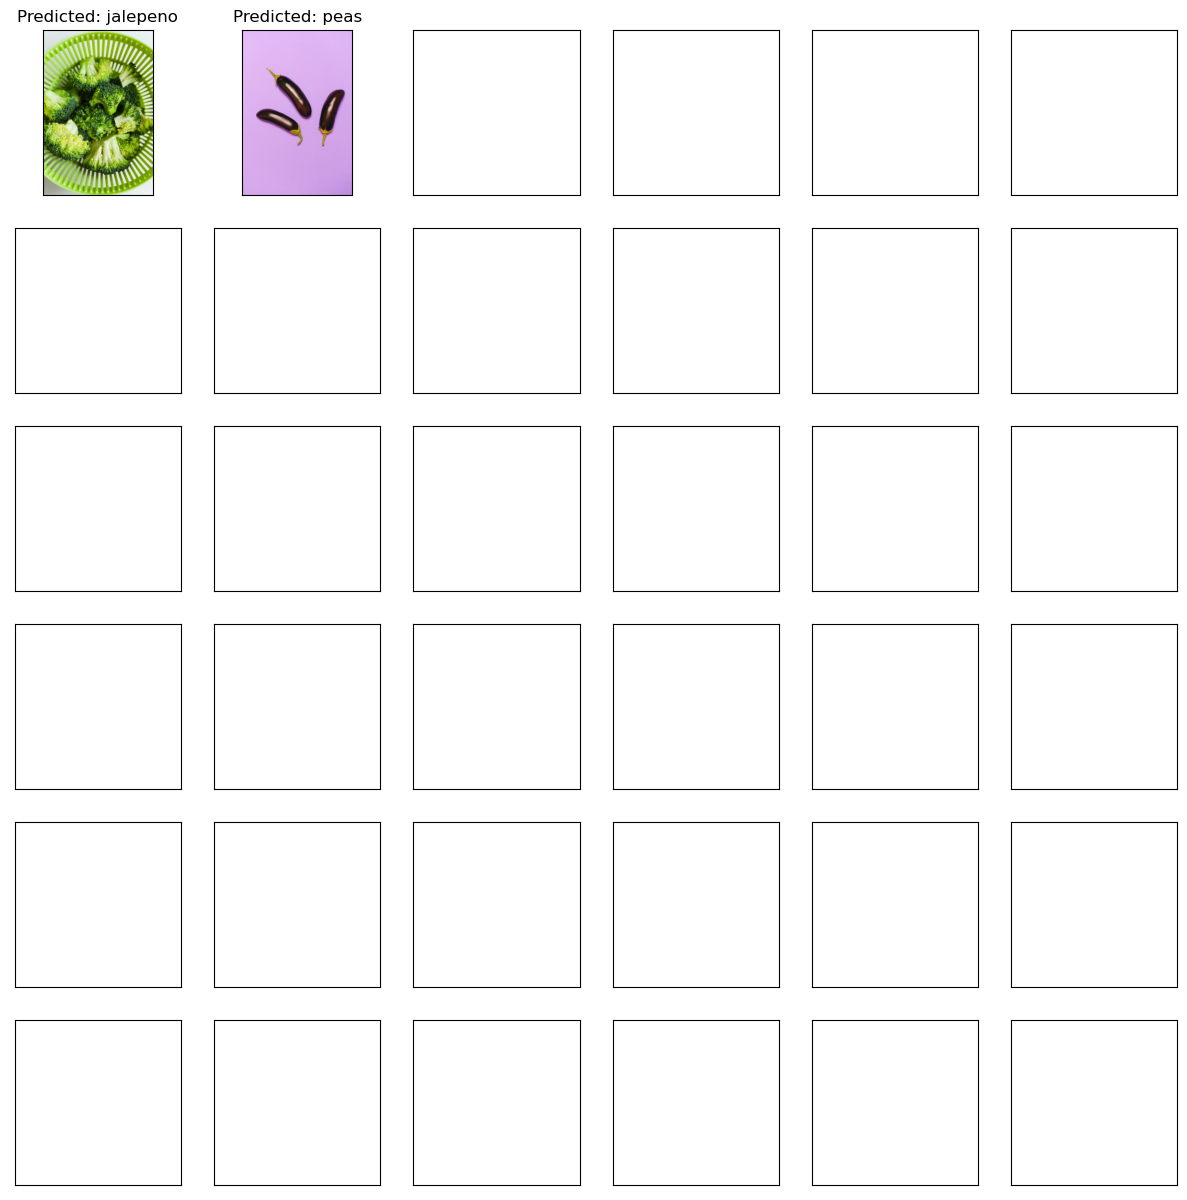

In [74]:
fig, axes = plt.subplots(6,6,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []}) #will see the actual and predicted labels with images.

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(user_input_df.FilePath.iloc[i]))
    ax.set_title(f"Predicted: {list(labels.keys())[pred[i]]}")
plt.tight_layout()
plt.show()